In [1]:
import tensorflow as tf
from keras import layers
from keras.models import Model, Sequential
from keras import backend as K
from sklearn.metrics import mean_squared_error
from skimage.measure import compare_ssim as SSIM
import numpy as np
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
_optimizer = Adam(0.0002, 0.5)
from keras import losses

# from tensorflow.keras import layers
# from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
def load_imgs(path, number, train_type):
    result=np.empty((number, 48, 48, 3), dtype="float64")
    for i in range(number):
#        if path == "./blurImg/"
        I = cv2.imread(path + "{:04}_{}.jpeg".format(i+1, train_type))
#         else:
#             I = cv2.imread(path + "{:04}_{}.jpeg".format(i+1001, train_type))
        #I = I[8:-8, 8:-8, :]
        result[i, :, :, :] = I
    return result/result.max()

In [3]:
# mask = np.random.randint(0, 1, (10000, 48, 48, 3))
# x_train1 = np.random.rand(10000, 48, 48, 3) * mask
# x_train2 = np.random.rand(10000, 48, 48, 3) * (1-mask)

# y_train = x_train1 + x_train2 + 0.25*np.random.rand(10000, 48, 48, 3)
# y_train = y_train[:, 8:-8, 8:-8, :]
dataNum = 4000
dataPath = "testcase_pro/"
x1 = load_imgs(dataPath, dataNum, 1)
x2 = load_imgs(dataPath, dataNum, 2)
y = load_imgs(dataPath, dataNum, 0)
y = y[:, 8:-8, 8:-8, :]
mask1 = load_imgs(dataPath, dataNum, 4)
mask1 = mask1[:, 8:-8, 8:-8, :1]
mask2 = 1-mask1
mask = np.concatenate((mask1, mask2), axis = 3)

x_train1, x_test1, x_train2, x_test2, y_train, y_test, mask_train, mask_test = train_test_split(
    x1, x2, y, mask, test_size=0.25)
#plt.imshow(y[212, :, :, :])
# mask_test = np.random.randint(0, 1, (2000, 48, 48, 3))
# x_test1 = np.random.rand(2000, 48, 48, 3) * mask_test
# x_test2 = np.random.rand(2000, 48, 48, 3) * (1-mask_test)

# y_test = x_test1 + x_test2 + 0.25*np.random.rand(2000, 48, 48, 3)
# y_test = y_test[:, 8:-8, 8:-8, :]

In [4]:
# input size: Nonex48x48x3
# output size: Nonex36x36x16
def pre_convblock(x):
    y = layers.Conv2D(filters = 16, kernel_size = (5, 5), padding = "valid", activation = "relu")(x)
    y = layers.Conv2D(filters = 32, kernel_size = (5, 5), padding = "valid", activation = "relu")(y)
    y = layers.Conv2D(filters = 16, kernel_size = (5, 5), padding = "valid", activation = "relu")(y)
    return y

In [5]:
# tensor format: [batch, in_height, in_width, in_channels]
# input size: Nonex36x36x32 (cat: 16+16)
# output size: Nonex32x32x2
# softmax is applied along the channel axis.
def post_convblock(x):
    y = layers.Conv2D(filters = 64, kernel_size=(3, 3), padding = "valid", activation = "relu")(x)
    y = layers.Conv2D(filters = 32, kernel_size=(1, 1), padding = "valid", activation = "relu")(y)
    y = layers.Conv2D(filters = 2, kernel_size=(3, 3), padding = "valid", activation = 'tanh')(y)
#    y = layers.Conv2D(filters = 2, kernel_size=(3, 3), padding = "valid")(y)

    y = layers.Softmax(axis = -1)(y)
    return y

In [6]:
# input: out-of-focus image block A & block B, which denote the same area of the whole picture.
#        each: 48x48x3
# output: 
def fusionnet(inTensor1, inTensor2):
    out1 = pre_convblock(inTensor1)
    out2 = pre_convblock(inTensor2)

    x = layers.Concatenate(axis = -1)([out1, out2])
    y = post_convblock(x)
    
    return y

In [7]:
def fusionnetPos(y):
    y, inTensor1, inTensor2 = y
## crop the input images to the same size as network output.
    inCrop1 = layers.Cropping2D(cropping=((8, 8), (8, 8)))(inTensor1)
    inCrop2 = layers.Cropping2D(cropping=((8, 8), (8, 8)))(inTensor2)
    #y1, y2 = tf.split(y, [1, 1], axis = 3)
    ## extend y1&y2 dimension to 3, consistant to color channels
    y1 = y[:, :, :, :1]
    y2 = y[:, :, :, 1:]
#     print(y1.shape)
#     print(y2.shape)
    y1 = K.tile(y1, [1, 1, 1, 3])
    y2 = K.tile(y2, [1, 1, 1, 3])
    y1 = layers.Multiply()([inCrop1, y1])
    y2 = layers.Multiply()([inCrop2, y2])
    y = layers.Add()([y1, y2])
#    print(y)
    return y

In [8]:
img1 = layers.Input(shape=(48, 48, 3))
img2 = layers.Input(shape=(48, 48, 3))
intermed = fusionnet(img1, img2)
# print(intermed)
pred = layers.Lambda(fusionnetPos)([intermed, img1, img2])
# print(pred)

In [ ]:
generator = Model(inputs = [img1, img2], outputs = [pred, intermed])
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 44, 44, 16)   1216        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 44, 44, 16)   1216        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (

In [ ]:
def tv_loss(y_true, y_pred):
    #mapping = tf.cast(y_pred > 0.5, y_pred.dtype)
    #loss = tf.reduce_mean(tf.image.total_variation(mapping))

#     mapping = 0.25 - tf.square(y_pred-0.5) # 0.25-(x-0.5)^2
    sigma = 0.2
    mu = 0.5
    mapping = tf.exp(-0.5*tf.square((y_pred - mu)/sigma))
    loss = tf.reduce_mean(mapping)
    return loss

In [ ]:
# lambda_tv = 1
# generator.compile(loss=[losses.mean_squared_error, 'mse'], loss_weights=[0, lambda_tv], optimizer= _optimizer)
# generator.fit([x_train1, x_train2], [y_train, mask_train], batch_size=64, epochs=5)



# prediction, a = generator.predict([x1, x2])
# get_layer_output = K.function([generator.layers[0].input, generator.layers[1].input],
#                                   [generator.layers[-2].output])

# layer_output = np.array(get_layer_output([x1, x2])[0])

# imgIdx = 6
# fig=plt.figure(figsize=(12, 12))
# columns = 6
# rows = 1
# fig.add_subplot(rows, columns, 1)
# plt.imshow(x1[imgIdx, 8:-8, 8:-8, :])
# fig.add_subplot(rows, columns, 2)
# plt.imshow(x2[imgIdx, 8:-8, 8:-8, :])
# fig.add_subplot(rows, columns, 3)
# plt.imshow(mask[imgIdx, :, :, 0])
# fig.add_subplot(rows, columns, 4)
# plt.imshow(layer_output[imgIdx, :, :, 0])
# fig.add_subplot(rows, columns, 5)
# plt.imshow(prediction[imgIdx, :, :, :])
# fig.add_subplot(rows, columns, 6)
# plt.imshow(y[imgIdx, :, :, :])
# plt.show()
# fig.savefig(dataPath+"results/struc_loss{:.2E}.png".format(lambda_tv))

In [ ]:
def dis_block(x, _filters, _strides, bn = True):
    y = layers.Conv2D(filters = _filters, kernel_size = (5, 5), strides = _strides, 
                      padding='same')(x)
    y = layers.LeakyReLU(alpha=0.2)(y)
    if bn:
        y = layers.BatchNormalization(momentum=0.8)(y)
    return y

In [ ]:
def disnet(x):
    y = dis_block(x, 32, (2, 2), bn = False)
    y = dis_block(y, 64, (1, 1))
    y = dis_block(y, 64, (2, 2))
    y = dis_block(y, 128, (1, 1))
    y = dis_block(y, 128, (2, 2))
#     y = dis_block(y, 256, (2, 2))
#     y = dis_block(y, 256, (2, 2))
    y = layers.Flatten()(y)
    y = layers.Dense(1, activation='sigmoid')(y)
    return y

In [ ]:
dis_input = layers.Input(shape=(32, 32, 3))
dis_output = disnet(dis_input)
discriminator = Model(inputs = dis_input, outputs = dis_output)
# make_trainable(discriminator, False)
#discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        2432      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 64)          102464    
__________

In [ ]:
# discriminator.compile(loss='mse', optimizer= _optimizer)
# y_fake = generator.predict([x_train1, x_train2])
# dis_input = np.concatenate((y_fake, y_train), axis = 0)
# label = np.append(np.zeros((y_fake.shape[0], )), np.ones((y_train.shape[0], )))

# for e in range(20):
#     discriminator.fit(dis_input, label)

# label = discriminator.predict(x_test1[:, 8:-8, 8:-8, :])
# print(np.sum(label < 0.5))
# print(label)

In [ ]:
def gannet(x):
    img1, img2 = x
    pred, intermed = generator([img1, img2])
    prob = discriminator(pred)
    discriminator.trainable = False
    return (prob, intermed)

In [ ]:
prob, intermed = gannet([img1, img2])
gan = Model(inputs = [img1, img2], outputs= [prob, intermed])
#gan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 32, 32, 3),  74882       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            774401      model_1[1][0]                    
Total para

In [ ]:
# prediction = gan.predict([x1, x2])
# mask = prediction[1]
# plt.imshow(mask[6, :, :, 0])
# mask_tensor = tf.convert_to_tensor(mask)
# tv = tf.image.total_variation(mask_tensor)
# sess = tf.Session()
# loss = tv.eval(session=sess)

# print(loss[:10]/32/32/2)

In [ ]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        #plt.plot(losses["mse"], label='mse')
        plt.legend()
        plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

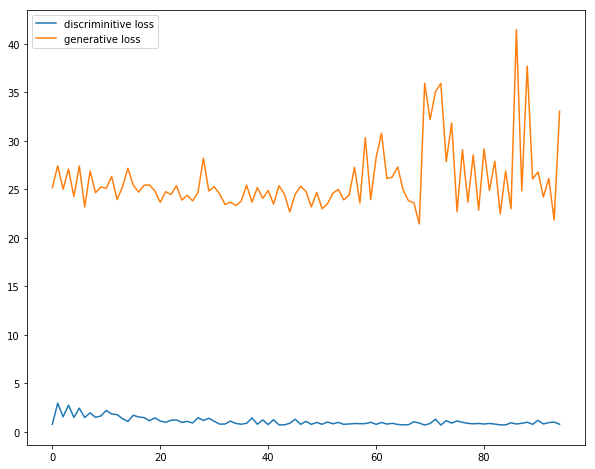

0.8278901902165714


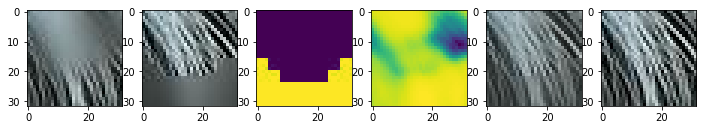

 50%|████▉     | 99/200 [1:53:31<4:21:02, 155.07s/it]

In [ ]:
epoch = 200
batchSize = 64
losses = {"d":[], "g":[], "mse":[]}
lambda_tv = 99
for e in tqdm(range(epoch)):
    rand_idx = np.random.randint(0, x_train1.shape[0], size = batchSize)
    img_batch1 = x_train1[rand_idx, :, :, :]
    img_batch2 = x_train2[rand_idx, :, :, :]
    mask_batch = mask_train[rand_idx, :, :, :]
    y_batch = y_train[np.random.randint(0, y_train.shape[0], size = batchSize), :, :, :]
    img_fake = generator.predict([img_batch1, img_batch2])[0]
    img_valid = y_batch
    dis_input = np.concatenate((img_fake, img_valid), axis = 0)
    label = np.append(np.zeros((batchSize, )), np.ones((batchSize, )))
    
    discriminator.trainable = True
    discriminator.compile(loss='binary_crossentropy', optimizer=_optimizer)
    d_loss = discriminator.train_on_batch(dis_input, label)
    losses["d"].append(d_loss)
    
    gan_label = np.ones((batchSize,))
    discriminator.trainable = False
    gan.compile(loss = ['binary_crossentropy', 'mse'], loss_weights=[1, lambda_tv], optimizer=_optimizer)

    g_loss = gan.train_on_batch([img_batch1, img_batch2], [gan_label, mask_batch])
#     g_loss[2] = g_loss[2]*10
    losses["g"].append(g_loss[0])
#     generator.compile(loss=['mse', 'mse'], loss_weights=[1, 0], optimizer= _optimizer)
#     mse_loss = generator.evaluate([x_test1, x_test2], [y_test, mask_test], batch_size=64, verbose=0)
#     losses["mse"].append(10*np.log10(1/mse_loss[0])/25)
    
    if e % 5 == 4:
#         lambda_tv = max(lambda_tv/10, 1)
        plot_loss(losses)

        imgIdx = 6
        prediction = generator.predict([x1[imgIdx:imgIdx+1, :, :, :], x2[imgIdx:imgIdx+1, :, :, :]])[0]
        ssim = SSIM(y[imgIdx, :, :, :], prediction[0, :, :, :], data_range=prediction[0, :, :, :].max() - prediction[0, :, :, :].min(), multichannel=True)
        print(ssim)
        
        get_layer_output = K.function([generator.layers[0].input, generator.layers[1].input],
                                          [generator.layers[-2].output])

        layer_output = np.array(get_layer_output([x1[imgIdx:imgIdx+1, :, :, :], x2[imgIdx:imgIdx+1, :, :, :]])[0])

        fig=plt.figure(figsize=(12, 12))
        columns = 6
        rows = 1
        fig.add_subplot(rows, columns, 1)
        plt.imshow(x1[imgIdx, 8:-8, 8:-8, :])
        fig.add_subplot(rows, columns, 2)
        plt.imshow(x2[imgIdx, 8:-8, 8:-8, :])
        fig.add_subplot(rows, columns, 3)
        plt.imshow(mask[imgIdx, :, :, 0])
        fig.add_subplot(rows, columns, 4)
        plt.imshow(layer_output[0, :, :, 0])
        fig.add_subplot(rows, columns, 5)
        plt.imshow(prediction[0, :, :, :])
        fig.add_subplot(rows, columns, 6)
        plt.imshow(y[imgIdx, :, :, :])
        plt.show()
#         fig.savefig(dataPath+"results/struc_ep{}_{}.png".format(e,lambda_tv))

In [ ]:
# prediction = generator.predict([x_test1, x_test2])
# get_layer_output = K.function([generator.layers[0].input, generator.layers[1].input],
#                                   [generator.layers[-2].output])

# layer_output = np.array(get_layer_output([x_test1, x_test2])[0])

# imgIdx = 6
# fig=plt.figure(figsize=(12, 12))
# columns = 5
# rows = 1
# fig.add_subplot(rows, columns, 1)
# plt.imshow(x_test1[imgIdx, 8:-8, 8:-8, :])
# fig.add_subplot(rows, columns, 2)
# plt.imshow(x_test2[imgIdx, 8:-8, 8:-8, :])
# fig.add_subplot(rows, columns, 3)
# plt.imshow(layer_output[imgIdx, :, :, 0])
# fig.add_subplot(rows, columns, 4)
# plt.imshow(prediction[0][imgIdx, :, :, :])
# fig.add_subplot(rows, columns, 5)
# plt.imshow(y_test[imgIdx, :, :, :])
# plt.show()